In [1]:
import numpy as np

In [2]:
data = open("HP1_paragraph1.txt").read().lower()

In [3]:
words = data.split()
len(words)

8124

In [4]:
split_index = int(0.8 * len(words))

train_data = words[:split_index]
test_data = words[split_index:]

In [5]:
len(set(train_data)-set(test_data))

1643

In [6]:
len(set(test_data)-set(train_data))

337

In [7]:
word_set = set(words)
word_set
word_to_idx = {w:i for i, w in enumerate(word_set)}
idx_to_word = {i:w for i, w in enumerate(word_set)}

In [8]:
word_size = len(word_set)
word_size

2336

In [9]:
def oneHotEncode(text):
    output = np.zeros((word_size, 1))
    output[word_to_idx[text]] = 1

    return output

# Xavier Normalized Initialization
def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))

##### Activation Functions #####
def sigmoid(input, derivative = False):
    if derivative:
        return input * (1 - input)

    return 1 / (1 + np.exp(-input))

def tanh(input, derivative = False):
    if derivative:
        return 1 - input ** 2

    return np.tanh(input)

def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))

##### Long Short-Term Memory Network Class #####
class LSTM:
    def __init__(self, input_size, hidden_size, output_size, num_epochs, learning_rate):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_epochs = num_epochs

        # Forget Gate
        self.wf = initWeights(input_size, hidden_size)
        self.bf = np.zeros((hidden_size, 1))

        # Input Gate
        self.wi = initWeights(input_size, hidden_size)
        self.bi = np.zeros((hidden_size, 1))

        # Candidate Gate
        self.wc = initWeights(input_size, hidden_size)
        self.bc = np.zeros((hidden_size, 1))

        # Output Gate
        self.wo = initWeights(input_size, hidden_size)
        self.bo = np.zeros((hidden_size, 1))

        # Final Gate
        self.wy = initWeights(hidden_size, output_size)
        self.by = np.zeros((output_size, 1))

    # Reset Network Memory
    def reset(self):
        self.concat_inputs = {}

        self.hidden_states = {-1:np.zeros((self.hidden_size, 1))}
        self.cell_states = {-1:np.zeros((self.hidden_size, 1))}

        self.activation_outputs = {}
        self.candidate_gates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}

    # Forward Propogation
    def forward(self, inputs):
        self.reset()

        outputs = []
        for q in range(len(inputs)):
            self.concat_inputs[q] = np.concatenate((self.hidden_states[q - 1], inputs[q]))

            self.forget_gates[q] = sigmoid(np.dot(self.wf, self.concat_inputs[q]) + self.bf)
            self.input_gates[q] = sigmoid(np.dot(self.wi, self.concat_inputs[q]) + self.bi)
            self.candidate_gates[q] = tanh(np.dot(self.wc, self.concat_inputs[q]) + self.bc)
            self.output_gates[q] = sigmoid(np.dot(self.wo, self.concat_inputs[q]) + self.bo)

            self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] + self.input_gates[q] * self.candidate_gates[q]
            self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

            outputs += [np.dot(self.wy, self.hidden_states[q]) + self.by]

        return outputs

    # Backward Propogation
    def backward(self, errors, inputs):
        d_wf, d_bf = 0, 0
        d_wi, d_bi = 0, 0
        d_wc, d_bc = 0, 0
        d_wo, d_bo = 0, 0
        d_wy, d_by = 0, 0

        dh_next, dc_next = np.zeros_like(self.hidden_states[0]), np.zeros_like(self.cell_states[0])
        for q in reversed(range(len(inputs))):
            error = errors[q]

            # Final Gate Weights and Biases Errors
            d_wy += np.dot(error, self.hidden_states[q].T)
            d_by += error

            # Hidden State Error
            d_hs = np.dot(self.wy.T, error) + dh_next

            # Output Gate Weights and Biases Errors
            d_o = tanh(self.cell_states[q]) * d_hs * sigmoid(self.output_gates[q], derivative = True)
            d_wo += np.dot(d_o, inputs[q].T)
            d_bo += d_o

            # Cell State Error
            d_cs = tanh(tanh(self.cell_states[q]), derivative = True) * self.output_gates[q] * d_hs + dc_next

            # Forget Gate Weights and Biases Errors
            d_f = d_cs * self.cell_states[q - 1] * sigmoid(self.forget_gates[q], derivative = True)
            d_wf += np.dot(d_f, inputs[q].T)
            d_bf += d_f

            # Input Gate Weights and Biases Errors
            d_i = d_cs * self.candidate_gates[q] * sigmoid(self.input_gates[q], derivative = True)
            d_wi += np.dot(d_i, inputs[q].T)
            d_bi += d_i

            # Candidate Gate Weights and Biases Errors
            d_c = d_cs * self.input_gates[q] * tanh(self.candidate_gates[q], derivative = True)
            d_wc += np.dot(d_c, inputs[q].T)
            d_bc += d_c

            # Concatenated Input Error (Sum of Error at Each Gate!)
            d_z = np.dot(self.wf.T, d_f) + np.dot(self.wi.T, d_i) + np.dot(self.wc.T, d_c) + np.dot(self.wo.T, d_o)

            # Error of Hidden State and Cell State at Next Time Step
            dh_next = d_z[:self.hidden_size, :]
            dc_next = self.forget_gates[q] * d_cs

        for d_ in (d_wf, d_bf, d_wi, d_bi, d_wc, d_bc, d_wo, d_bo, d_wy, d_by):
            np.clip(d_, -1, 1, out = d_)

        self.wf += d_wf * self.learning_rate
        self.bf += d_bf * self.learning_rate

        self.wi += d_wi * self.learning_rate
        self.bi += d_bi * self.learning_rate

        self.wc += d_wc * self.learning_rate
        self.bc += d_bc * self.learning_rate

        self.wo += d_wo * self.learning_rate
        self.bo += d_bo * self.learning_rate

        self.wy += d_wy * self.learning_rate
        self.by += d_by * self.learning_rate

    # Train
    def train(self, inputs, labels):
        inputs = [oneHotEncode(input) for input in inputs]

        loss = []
        average_loss = []
        accuracy_list = []

        for _ in range(self.num_epochs):
            predictions = self.forward(inputs)

            errors = []
            l = 0
            accuracy = 0
            for q in range(len(predictions)):
                errors += [-softmax(predictions[q])]
                errors[-1][word_to_idx[labels[q]]] += 1

                l += -np.log(softmax(predictions[q])[word_to_idx[labels[q]]])

                prediction = str(idx_to_word[np.random.choice([*range(word_size)], p = softmax(predictions[q].reshape(-1)))])
                if prediction == labels[q]:
                    accuracy += 1

            loss.append(l)
            average_loss.append(l/len(predictions))
            accuracy_list.append((accuracy/len(labels))*100)

            if (_ == 0) | ((_+1)%20==0):
                print(f"Epoch: {_+1}, Loss: {loss[_]}, Average Loss: {average_loss[_]}, Accuracy: {accuracy_list[_]} \n")

            self.backward(errors, self.concat_inputs)

        return loss, average_loss, accuracy_list

    # Test
    def test(self, inputs, labels):
        accuracy = 0
        predictions = self.forward([oneHotEncode(input) for input in inputs])

        output = []
        for q in range(len(labels)):
            prediction = str(idx_to_word[np.random.choice([*range(word_size)], p = softmax(predictions[q].reshape(-1)))])

            output.append(prediction)

            if prediction == labels[q]:
                accuracy += 1

        print(f'Ground Truth:\nt{labels}\n')
        print(f'Predictions:\nt{output}\n')

        print(f'Accuracy: {round(accuracy * 100 / len(labels), 2)}%')

In [11]:
# Initialize Network
hidden_size = 25
lstm = LSTM(input_size = word_size + hidden_size, hidden_size = hidden_size, output_size = word_size, num_epochs = 1000, learning_rate = 0.1)

##### Training #####
train_X, train_y = train_data[:-1], train_data[1:]
train_loss_sum, train_loss_mean, train_accuracy = lstm.train(train_X, train_y)

Epoch: 1, Loss: [50399.80328345], Average Loss: [7.75620241], Accuracy: 0.07694675284702986 

Epoch: 20, Loss: [48139.57240066], Average Loss: [7.40836756], Accuracy: 1.5851031086488152 

Epoch: 40, Loss: [44818.64307605], Average Loss: [6.8972981], Accuracy: 2.9855340104647583 

Epoch: 60, Loss: [37843.0018751], Average Loss: [5.82379222], Accuracy: 2.8778085564789166 

Epoch: 80, Loss: [32024.27126347], Average Loss: [4.92832737], Accuracy: 4.647583871960603 

Epoch: 100, Loss: [27972.01471097], Average Loss: [4.30471141], Accuracy: 5.093875038473376 

Epoch: 120, Loss: [25068.0122491], Average Loss: [3.85780429], Accuracy: 6.740535549399815 

Epoch: 140, Loss: [22713.057928], Average Loss: [3.49539211], Accuracy: 8.433364112034472 

Epoch: 160, Loss: [20884.94072529], Average Loss: [3.21405674], Accuracy: 10.634041243459526 

Epoch: 180, Loss: [19388.42650189], Average Loss: [2.98375292], Accuracy: 13.434903047091412 

Epoch: 200, Loss: [18923.59495215], Average Loss: [2.91221837], 

In [12]:
lstm.test(train_data[:-1], train_data[1:])

Ground Truth:
t['potter', 'and', 'the', "sorcerer's", 'stone', 'chapter', 'one', 'the', 'boy', 'who', 'lived', 'mr.', 'and', 'mrs.', 'dursley,', 'of', 'number', 'four,', 'privet', 'drive,', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal,', 'thank', 'you', 'very', 'much.', 'they', 'were', 'the', 'last', 'people', "you'd", 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious,', 'because', 'they', 'just', "didn't", 'hold', 'with', 'such', 'nonsense.', 'mr.', 'dursley', 'was', 'the', 'director', 'of', 'a', 'firm', 'called', 'grunnings,', 'which', 'made', 'drills.', 'he', 'was', 'a', 'big,', 'beefy', 'man', 'with', 'hardly', 'any', 'neck,', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mustache.', 'mrs.', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck,', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning'

In [13]:
test_X, test_y = test_data[:-1], test_data[1:]
lstm.test(test_X, test_y)

Ground Truth:
t['but', 'certainly', "wouldn't", 'fit', 'harry.', 'aunt', 'petunia', 'had', 'decided', 'it', 'must', 'have', 'shrunk', 'in', 'the', 'wash', 'and,', 'to', 'his', 'great', 'relief,', 'harry', "wasn't", 'punished.', 'on', 'the', 'other', 'hand,', "he'd", 'gotten', 'into', 'terrible', 'trouble', 'for', 'being', 'found', 'on', 'the', 'roof', 'of', 'the', 'school', 'kitchens.', "dudley's", 'gang', 'had', 'been', 'chasing', 'him', 'as', 'usual', 'when,', 'as', 'much', 'to', "harry's", 'surprise', 'as', 'anyone', "else's,", 'there', 'he', 'was', 'sitting', 'on', 'the', 'chimney.', 'the', 'dursleys', 'had', 'received', 'a', 'very', 'angry', 'letter', 'from', "harry's", 'headmistress', 'telling', 'them', 'harry', 'had', 'been', 'climbing', 'school', 'buildings.', 'but', 'all', "he'd", 'tried', 'to', 'do', '(as', 'he', 'shouted', 'at', 'uncle', 'vernon', 'through', 'the', 'locked', 'door', 'of', 'his', 'cupboard)', 'was', 'jump', 'behind', 'the', 'big', 'trash', 'cans', 'outside', 

Text(0, 0.5, 'training loss')

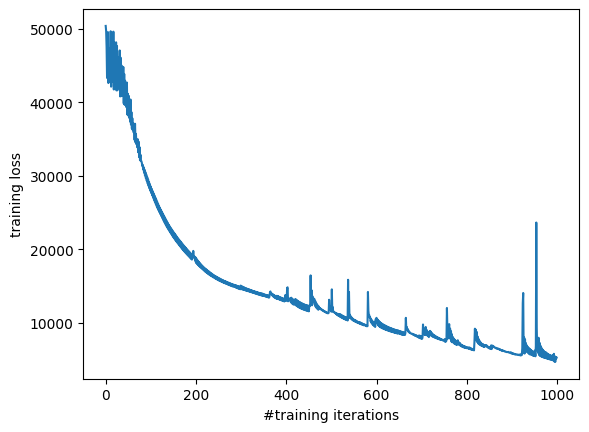

In [14]:
import pylab as plt

plt.plot([i for i in range(len(train_loss_sum))], train_loss_sum)
plt.xlabel("#training iterations")
plt.ylabel("training loss")

Text(0, 0.5, 'mean training loss')

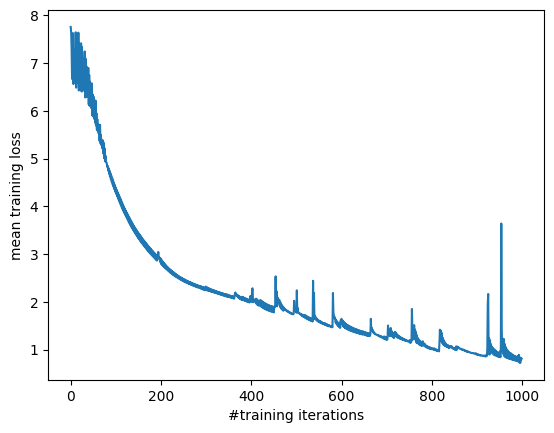

In [15]:
plt.plot([i for i in range(len(train_loss_mean))], train_loss_mean)
plt.xlabel("#training iterations")
plt.ylabel("mean training loss")

In [16]:
import random
train_data_shuffled = np.copy(train_data)
random.shuffle(train_data_shuffled)

lstm.test(train_data_shuffled[:-1], train_data_shuffled[1:])

Ground Truth:
t['bed.' 'inside' 'dozen' ... 'mind' 'woken' 'back.']

Predictions:
t['said', 'another', 'said', 'on', 'have', 'full', "he's", 'meanwhile,', 'where', 'the', 'trust', 'when', 'he', 'but', 'most', 'all', 'going', 'father.', 'as', 'rumors', 'motorcycle', 'had', 'had', 'and', 'sister', 'tell', 'dudley', 'been', 'from', 'but', 'he', 'on', 'computer', 'fact,', 'all', 'had', 'he', 'his', 'sight', 'the', 'over', 'struck', 'he', 'over', 'the', 'see', 'owl', 'saying,', 'it.', 'that', 'starts,', 'have', 'asked.', "you'll", 'drive', 'of', 'sightings', '--', "wasn't", 'shooting', 'that', 'a', 'been', 'boy', 'that', 'have', 'back', "they're", 'were', "wouldn't", "didn't", 'nose', 'of', 'dumbledore,', 'the', "he's", 'said', 'a', "i'm", 'bacon', 'just', 'muggle', 'name.', 'the', 'the', 'who', 'instead', 'first', 'house.', 'that', 'into', "'you-know-who.'", 'computer', 'harry', "didn't", 'over', 'that', 'least', 'the', 'gotten', 'day.', 'left', 'first', 'anyone', 'on', 'his', 'harry', 'ov

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
def word_count(paragraph):
  word_count = 0
  for i in range(len(paragraph)):
      if paragraph[i] == ' ' or paragraph[i] == '\n':
        word_count += 1
  return word_count

In [19]:
chars = set(data)
data_size, char_size = len(data), len(chars)
print(f'Data size: {data_size}, Char Size: {char_size}')
print(data[:10])
word_count_data = word_count(data)
print(f'word_count_data = {word_count_data}')

Data size: 45416, Char Size: 40
harry pott
word_count_data = 8579


In [20]:
split_index = int(0.8 * len(data))

while data[split_index] != ' ' and data[split_index] != '\n':
  split_index += 1

train_data = data[:split_index]
test_data = data[split_index:]

print(f'Training data size: {len(train_data)}, Training char size: {len(set(train_data))}')
print(f'Test data size: {len(test_data)}, Test char size: {len(set(test_data))}')

word_count_train = word_count(train_data)
word_count_test = word_count(test_data)
print(f'word_count_train = {word_count_train}')
print(f'word_count_test = {word_count_test}')

print(f'train_data = {train_data}')
print(f'test_data = {test_data}')

Training data size: 36332, Training char size: 40
Test data size: 9084, Test char size: 39
word_count_train = 6852
word_count_test = 1727
train_data = harry potter and the sorcerer's stone 

chapter one 

the boy who lived 

mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much. they were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. 

mr. dursley was the director of a firm called grunnings, which made drills. he was a big, beefy man with hardly any neck, although he did have a very large mustache. mrs. dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. the dursleys had a small son called dudley and in their opinion there was no finer boy anywhere. 

the dursleys had everything they wanted, but they als

In [21]:
# Sample paragraph
paragraph = train_data

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([paragraph])
total_words = len(tokenizer.word_index) + 1

# Create input sequences using list of tokens
input_sequences = []
for line in paragraph.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences to ensure uniform length
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create predictors and label
X, y = input_sequences[:,:-1],input_sequences[:,-1]

# Define the LSTM model
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
model.fit(X, y, epochs=100, verbose=1)


Epoch 1/100
197/197 [==============================] - 41s 188ms/step - loss: 6.4982 - accuracy: 0.0437
Epoch 2/100
197/197 [==============================] - 28s 142ms/step - loss: 6.0592 - accuracy: 0.0449
Epoch 3/100
197/197 [==============================] - 28s 142ms/step - loss: 5.9691 - accuracy: 0.0453
Epoch 4/100
197/197 [==============================] - 30s 153ms/step - loss: 5.8517 - accuracy: 0.0515
Epoch 5/100
197/197 [==============================] - 28s 143ms/step - loss: 5.7237 - accuracy: 0.0586
Epoch 6/100
197/197 [==============================] - 28s 143ms/step - loss: 5.5718 - accuracy: 0.0767
Epoch 7/100
197/197 [==============================] - 28s 143ms/step - loss: 5.4004 - accuracy: 0.0951
Epoch 8/100
197/197 [==============================] - 28s 143ms/step - loss: 5.2232 - accuracy: 0.1077
Epoch 9/100
197/197 [==============================] - 29s 148ms/step - loss: 5.0571 - accuracy: 0.1181
Epoch 10/100
197/197 [==============================] - 29s 148m

In [22]:
# Function to generate text given a seed text
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_index = np.argmax(predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Generate text
first_word_index = 1
while test_data[first_word_index] != ' ' and test_data[first_word_index] != '\n':
  first_word_index += 1
test_paragraph = test_data[:first_word_index]
print(f'test_paragraph = {test_paragraph}')
generated_text = generate_text(test_paragraph, word_count_test, model, max_sequence_len)
print(generated_text)


test_paragraph =  it
 it was on the corner of the street that he noticed the first sign of something peculiar a cat reading a map for a second mr dursley didn't realize what he had seen then he jerked his head around to look again there was a tabby cat standing on the corner of privet drive but there wasn't a map in sight what could he have been thinking of it must have been a trick of the light mr dursley blinked and stared at the cat it stared back as mr dursley drove around the corner and up the road he watched the cat in his mirror it was now reading the sign that said privet drive no looking at the sign cats couldn't read maps or signs mr dursley gave himself a little shake and put the cat out of his mind as he drove toward town he thought of nothing except a large order of drills he was hoping to get that day in the ground on the contrary his face split into a wide smile and he said in a squeaky voice that made passersby stare don't be sorry my dear sir for nothing could upset me

In [23]:
# Function to generate text given a seed text
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_index = np.argmax(predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
    return output_word

# Generate text
first_word_index = 1
while test_data[first_word_index] != ' ' and test_data[first_word_index] != '\n':
  first_word_index += 1
test_paragraph = test_data.split()[:-1]
print(f'test_paragraph = {test_paragraph}')
generated_text = test_data[:first_word_index]
for text in test_paragraph:
  word = generate_text(text, 1, model, max_sequence_len)
  generated_text += " " + word

print(generated_text)


test_paragraph = ['it', 'seemed', 'to', 'become,', 'until', 'finally', 'it', 'might', 'have', 'fitted', 'a', 'hand', 'puppet,', 'but', 'certainly', "wouldn't", 'fit', 'harry.', 'aunt', 'petunia', 'had', 'decided', 'it', 'must', 'have', 'shrunk', 'in', 'the', 'wash', 'and,', 'to', 'his', 'great', 'relief,', 'harry', "wasn't", 'punished.', 'on', 'the', 'other', 'hand,', "he'd", 'gotten', 'into', 'terrible', 'trouble', 'for', 'being', 'found', 'on', 'the', 'roof', 'of', 'the', 'school', 'kitchens.', "dudley's", 'gang', 'had', 'been', 'chasing', 'him', 'as', 'usual', 'when,', 'as', 'much', 'to', "harry's", 'surprise', 'as', 'anyone', "else's,", 'there', 'he', 'was', 'sitting', 'on', 'the', 'chimney.', 'the', 'dursleys', 'had', 'received', 'a', 'very', 'angry', 'letter', 'from', "harry's", 'headmistress', 'telling', 'them', 'harry', 'had', 'been', 'climbing', 'school', 'buildings.', 'but', 'all', "he'd", 'tried', 'to', 'do', '(as', 'he', 'shouted', 'at', 'uncle', 'vernon', 'through', 'the',

In [24]:
#calculate accuracy by char
print(f'len(test_data) = {len(test_data)}')
print(f'len(generated_text) = {len(generated_text)}\n')
min_len = min(len(test_data), len(generated_text))

print(f'test_data = {test_data}\n')
print(type(test_data))
print(f'generated_text = {generated_text}')
print(generated_text)
match_count = 0
for i in range(min_len):
  if test_data[i] == generated_text[i]:
    match_count += 1
accuracy = match_count / min_len
print(f'accuracy = {round(accuracy * 100, 2)}%')

len(test_data) = 9084
len(generated_text) = 8602

test_data =  it seemed to become, until finally it might have fitted a hand puppet, but certainly wouldn't fit harry. aunt petunia had decided it must have shrunk in the wash and, to his great relief, harry wasn't punished. 

on the other hand, he'd gotten into terrible trouble for being found on the roof of the school kitchens. dudley's gang had been chasing him as usual when, as much to harry's surprise as anyone else's, there he was sitting on the chimney. the dursleys had received a very angry letter from harry's headmistress telling them harry had been climbing school buildings. but all he'd tried to do (as he shouted at uncle vernon through the locked door of his cupboard) was jump behind the big trash cans outside the kitchen doors. harry supposed that the wind must have caught him in mid- jump. 

but today, nothing was going to go wrong. it was even worth being with dudley and piers to be spending the day somewhere that wasn't s

In [25]:
#calculate accuracy by char
print(f'len(test_data) = {len(test_data)}')
print(f'len(generated_text) = {len(generated_text)}\n')
min_len = min(len(test_data), len(generated_text))

test_data_list = test_data.split()
generated_text_list = generated_text.split()
min_len_list = min(len(test_data_list), len(generated_text_list))

print(f'test_data_list = {test_data_list}\n')
print(f'generated_text_list = {generated_text_list}')

print(f'test_data = {test_data}\n')
print(f'generated_text = {generated_text}')

match_count = 0
for i in range(min_len):
  if test_data[i] == generated_text[i]:
    match_count += 1
accuracy = match_count / min_len

match_count_word = 0
for i in range(min_len_list):
  if test_data_list[i] == generated_text_list[i]:
    match_count_word += 1
accuracy_1 = match_count_word / min_len_list

print(f'accuracy letter = {round(accuracy * 100, 2)}%')
print(f'accuracy word = {round(accuracy_1 * 100, 2)}%')

len(test_data) = 9084
len(generated_text) = 8602

test_data_list = ['it', 'seemed', 'to', 'become,', 'until', 'finally', 'it', 'might', 'have', 'fitted', 'a', 'hand', 'puppet,', 'but', 'certainly', "wouldn't", 'fit', 'harry.', 'aunt', 'petunia', 'had', 'decided', 'it', 'must', 'have', 'shrunk', 'in', 'the', 'wash', 'and,', 'to', 'his', 'great', 'relief,', 'harry', "wasn't", 'punished.', 'on', 'the', 'other', 'hand,', "he'd", 'gotten', 'into', 'terrible', 'trouble', 'for', 'being', 'found', 'on', 'the', 'roof', 'of', 'the', 'school', 'kitchens.', "dudley's", 'gang', 'had', 'been', 'chasing', 'him', 'as', 'usual', 'when,', 'as', 'much', 'to', "harry's", 'surprise', 'as', 'anyone', "else's,", 'there', 'he', 'was', 'sitting', 'on', 'the', 'chimney.', 'the', 'dursleys', 'had', 'received', 'a', 'very', 'angry', 'letter', 'from', "harry's", 'headmistress', 'telling', 'them', 'harry', 'had', 'been', 'climbing', 'school', 'buildings.', 'but', 'all', "he'd", 'tried', 'to', 'do', '(as', 'he', 'sh

In [26]:
import random
print(type(test_data))
test_data_shuffled = test_data.split()
random.shuffle(test_data_shuffled)

generated_text = generate_text(test_data_shuffled[0], word_count_test, model, max_sequence_len)
print(generated_text)
#calculate accuracy by char
print(f'len(test_data) = {len(test_data)}')
print(f'len(generated_text) = {len(generated_text)}\n')
min_len = min(len(test_data), len(generated_text))

test_data_list = test_data.split()
generated_text_list = generated_text.split()
min_len_list = min(len(test_data_list), len(generated_text_list))

print(f'test_data_list = {test_data_list}\n')
print(f'generated_text_list = {generated_text_list}')

print(f'test_data = {test_data}\n')
print(f'generated_text = {generated_text}')

match_count = 0
for i in range(min_len):
  if test_data[i] == generated_text[i]:
    match_count += 1
accuracy = match_count / min_len

match_count_word = 0
for i in range(min_len_list):
  if test_data_list[i] == generated_text_list[i]:
    match_count_word += 1
accuracy_1 = match_count_word / min_len_list

print(f'accuracy letter = {round(accuracy * 100, 2)}%')
print(f'accuracy word = {round(accuracy_1 * 100, 2)}%')

<class 'str'>
saying
len(test_data) = 9084
len(generated_text) = 6

test_data_list = ['it', 'seemed', 'to', 'become,', 'until', 'finally', 'it', 'might', 'have', 'fitted', 'a', 'hand', 'puppet,', 'but', 'certainly', "wouldn't", 'fit', 'harry.', 'aunt', 'petunia', 'had', 'decided', 'it', 'must', 'have', 'shrunk', 'in', 'the', 'wash', 'and,', 'to', 'his', 'great', 'relief,', 'harry', "wasn't", 'punished.', 'on', 'the', 'other', 'hand,', "he'd", 'gotten', 'into', 'terrible', 'trouble', 'for', 'being', 'found', 'on', 'the', 'roof', 'of', 'the', 'school', 'kitchens.', "dudley's", 'gang', 'had', 'been', 'chasing', 'him', 'as', 'usual', 'when,', 'as', 'much', 'to', "harry's", 'surprise', 'as', 'anyone', "else's,", 'there', 'he', 'was', 'sitting', 'on', 'the', 'chimney.', 'the', 'dursleys', 'had', 'received', 'a', 'very', 'angry', 'letter', 'from', "harry's", 'headmistress', 'telling', 'them', 'harry', 'had', 'been', 'climbing', 'school', 'buildings.', 'but', 'all', "he'd", 'tried', 'to', 'do'

In [27]:
import random
print(type(test_data))
test_data_shuffled = test_data.split()
random.shuffle(test_data_shuffled)
print(test_data_shuffled)
# Generate text
test_paragraph = test_data_shuffled[:-1]
print(f'test_paragraph = {test_paragraph}')
generated_text = test_data_shuffled[0]
for text in test_paragraph:
  word = generate_text(text, 1, model, max_sequence_len)
  #print(word)
  generated_text += " " + word

print(generated_text)
#calculate accuracy by char
print(f'len(test_data) = {len(test_data)}')
print(f'len(generated_text) = {len(generated_text)}\n')
min_len = min(len(test_data), len(generated_text))

test_data_list = test_data.split()
generated_text_list = generated_text.split()
min_len_list = min(len(test_data_list), len(generated_text_list))

print(f'test_data_list = {test_data_list}\n')
print(f'generated_text_list = {generated_text_list}')

print(f'test_data = {test_data}\n')
print(f'generated_text = {generated_text}')

match_count = 0
for i in range(min_len):
  if test_data[i] == generated_text[i]:
    match_count += 1
accuracy = match_count / min_len

match_count_word = 0
for i in range(min_len_list):
  if test_data_list[i] == generated_text_list[i]:
    match_count_word += 1
accuracy_1 = match_count_word / min_len_list

print(f'accuracy letter = {round(accuracy * 100, 2)}%')
print(f'accuracy word = {round(accuracy_1 * 100, 2)}%')

<class 'str'>
['a', 'it', 'had', 'a', 'had', 'to', 'the', 'nose', 'away,', 'where', 'you,"', 'mrs.', 'at', 'the', 'was', 'them', 'harry,', 'very', 'a', 'all', 'long', 'he', 'looked', 'that', 'to', 'crushed', 'complain', 'a', 'day', 'beet', 'crawling', 'later,', 'to', 'and', 'once', 'was', 'smiling', 'slid', 'had', 'but', 'was', 'there', 'it', 'they', 'have', 'were', 'it.', "he'd", 'a', 'do', 'he', 'had', 'at', 'great', 'of', 'jabbed', 'to', 'down', 'a', 'him.', 'were', 'to', 'lady', 'snake', 'tantrum', 'to', 'the', 'course', 'again', 'food.', 'or', 'in', 'him,', 'yet', 'and', 'the', 'waved', 'entrance', 'died', 'to', 'little', 'house.', 'a', 'and', 'jump.', 'died', 'had', 'while', 'letter', 'sure', 'piers', 'old', 'he', 'and', 'the', 'heels', 'on', 'at', 'aunt', 'best', 'wood', 'murmured', 'dudley', 'anyway?"', 'jump.', 'puppet,', 'the', 'the', 'snake', 'young', 'the', 'and', 'disturb', 'parents', 'dudley', 'like', 'because', 'the', 'lunchtime,', '--', 'it', 'ice', "wasn't", 'the', 'mu